In [82]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from lime import lime_tabular

from preprocessing import preprocess
from cluster import *
from baseline import train_val_split, baseline_model

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_cluster_path = '../labels/'
data_path = '../data/'
course = 'dsp_001'
path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
hard_fail = path + 'feature_labels.csv'
percentile = 0.6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
x_train, x_test, x_val, y_train, y_test, y_val, feature_names, patterns = preprocess(course, path, percentile, feature_types, metadata, hard_fail)

In [7]:
# Concat features & labels
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)
P = np.concatenate(patterns, axis=0)

In [8]:
labels = np.loadtxt(labels_cluster_path+'kmeans/baseline_cluster_labels.txt', dtype=int)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
predict_fn = lambda x: np.array([[1-baseline.predict(x)], [baseline.predict(x)]]).reshape(2,-1).T

In [71]:
idx = np.where(labels == 0)[0]
X_train = X[idx]
Y_train = Y[idx]
x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)

baseline_params = {
'name': 'baseline-32u-1l',
'optimizer': 'adam',
'loss': 'binary_crossentropy',
'metrics': ['binary_accuracy'],
'epochs': 20,
'batch_size': 64,
'verbose': 1
}
baseline = baseline_model()

baseline.load_weights(MODEL_PATH + 'baseline_classifier_for_cluster_'+str(c)).expect_partial()

explainer = lime_tabular.RecurrentTabularExplainer(x_train, mode='classification',
#                                                discretize_continuous=True,
                                               categorical_names = feat_names,
                                               class_names=['Pass', 'Fail'], 
                                               training_labels=y_train, feature_names=feature_names,
                                                  )

instances = random.sample([i for i in range(len(x_train))], 100)
explainers = []
for i in instances:
    exp=explainer.explain_instance(x_train[i], predict_fn, num_features=10, labels=(1,))
    explainers.append(exp)

In [51]:
i = 1
exp=explainer.explain_instance(x_train[i], predict_fn, num_features=10, labels=(1,))
exp.show_in_notebook(show_table=True)

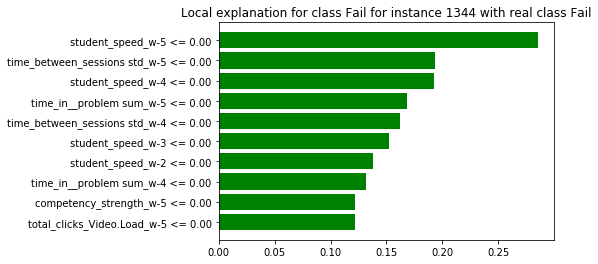

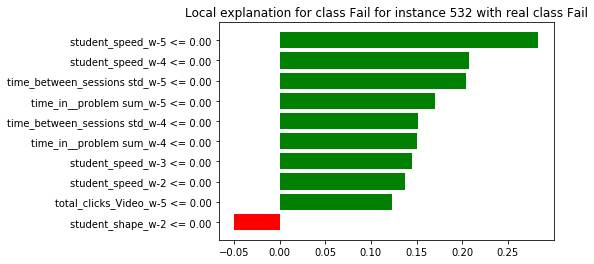

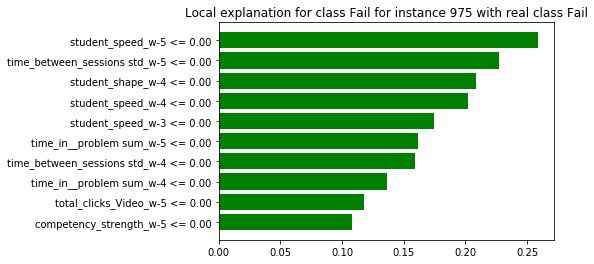

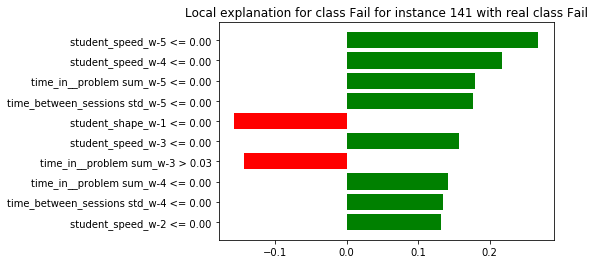

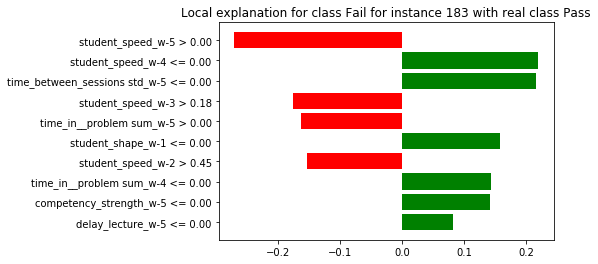

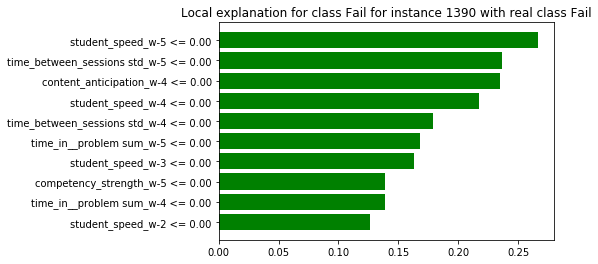

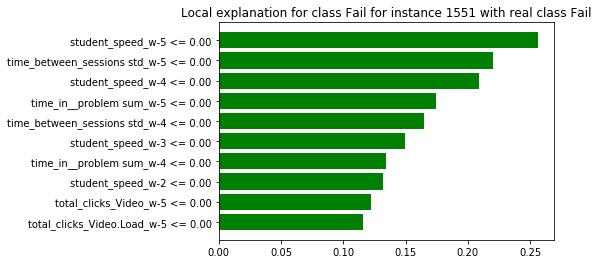

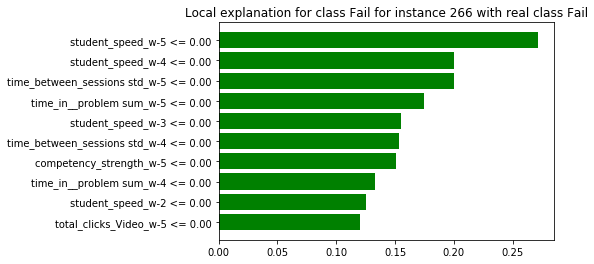

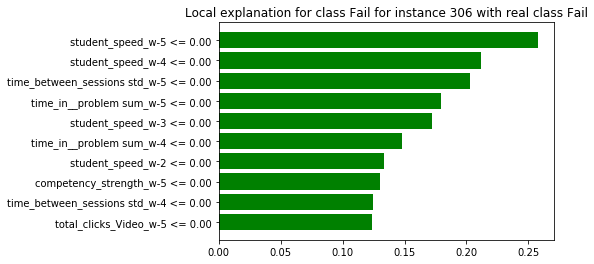

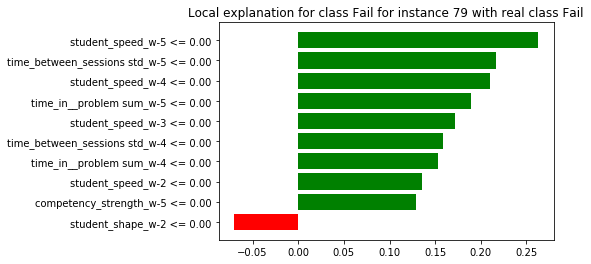

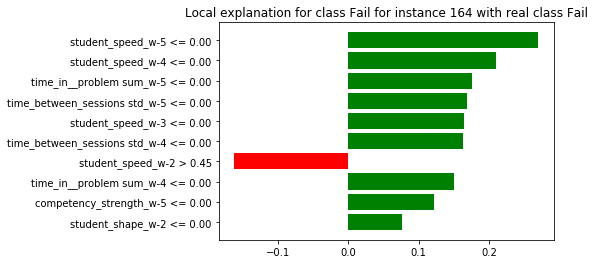

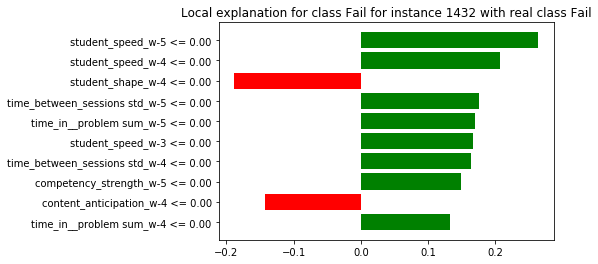

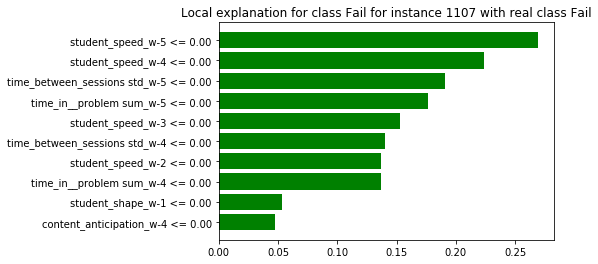

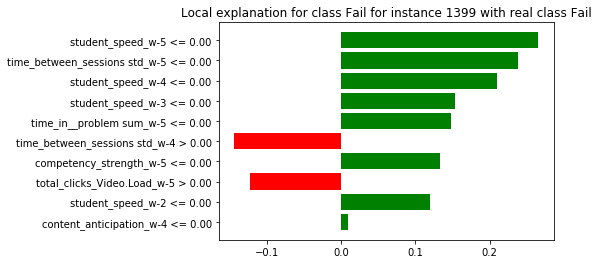

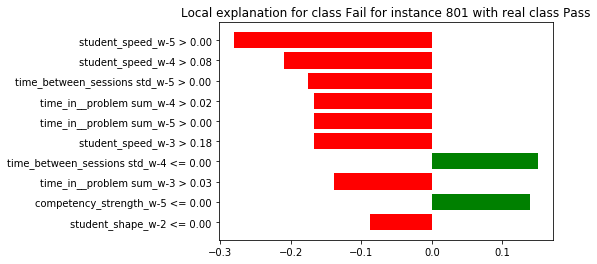

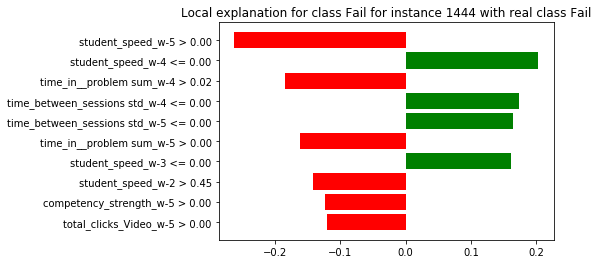

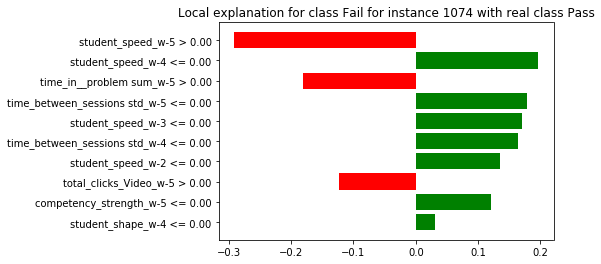

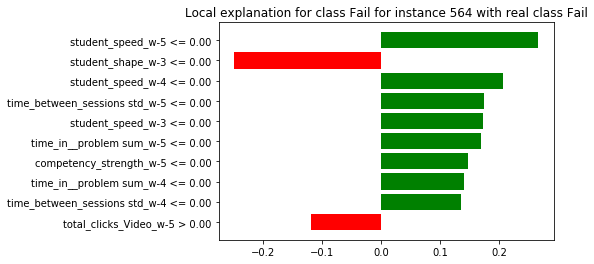

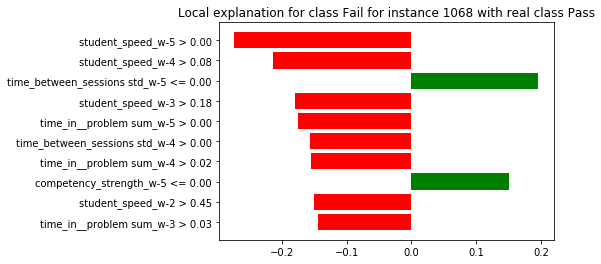

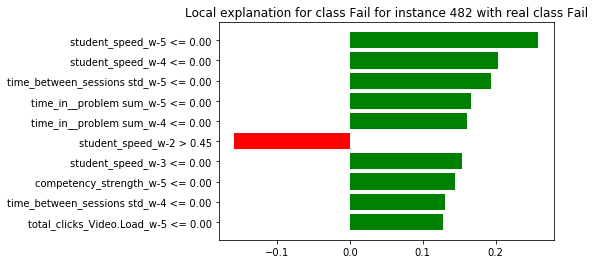

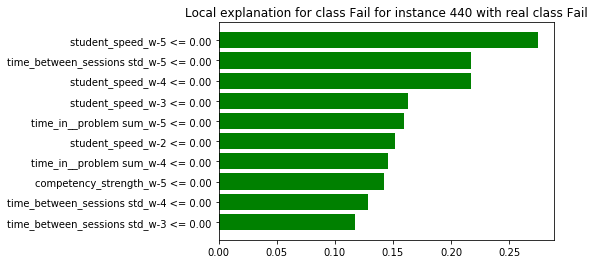

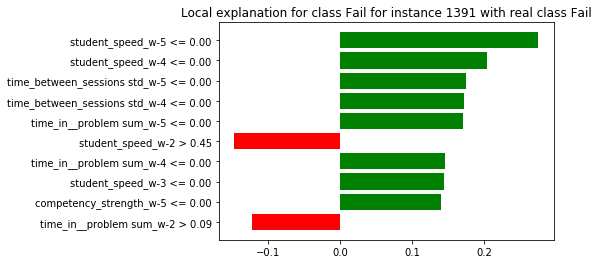

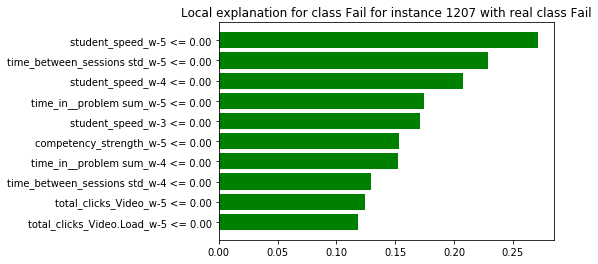

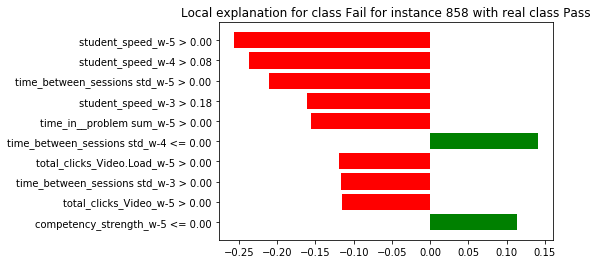

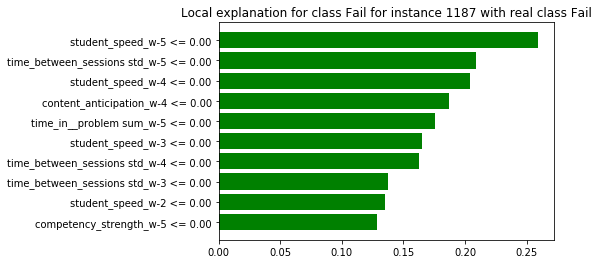

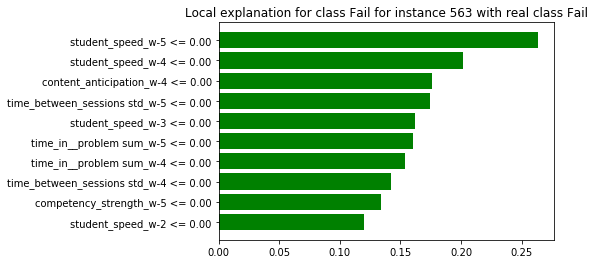

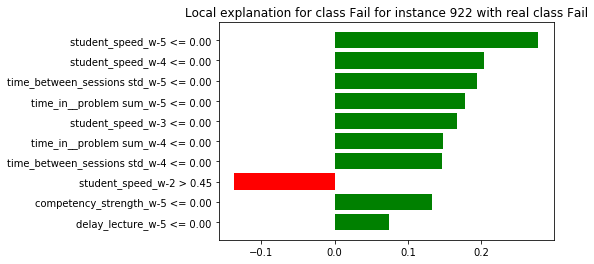

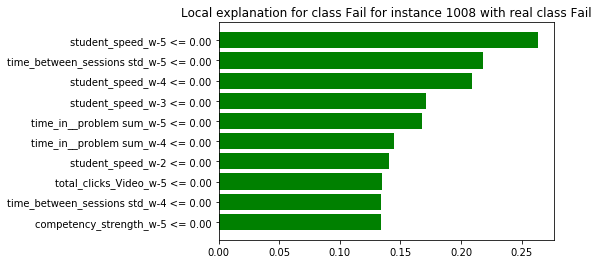

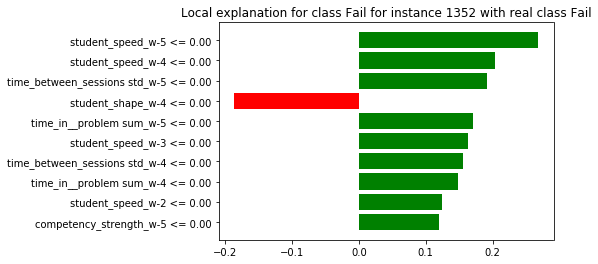

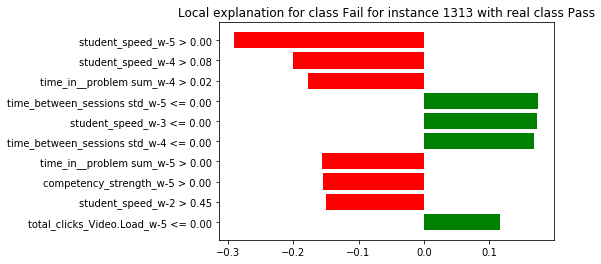

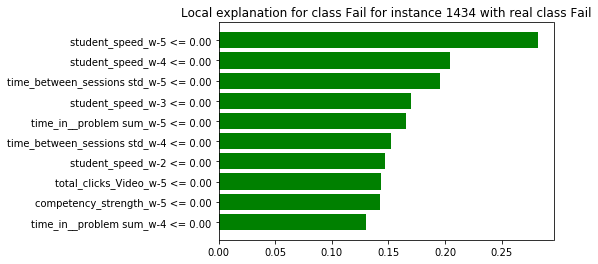

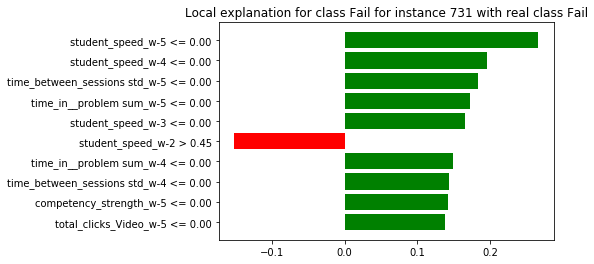

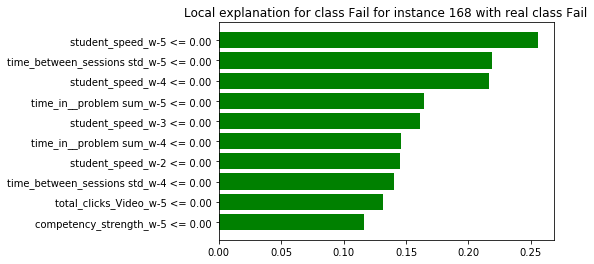

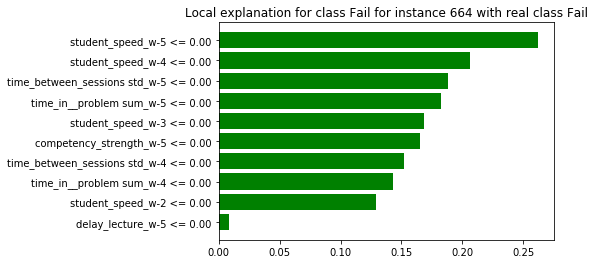

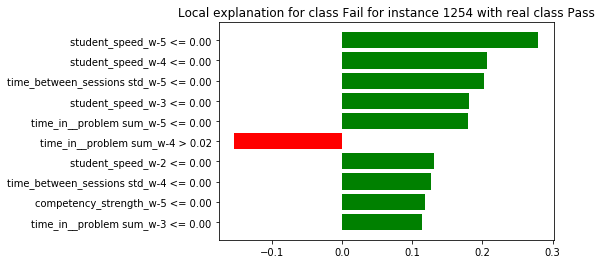

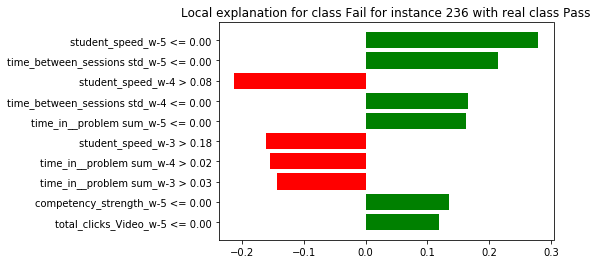

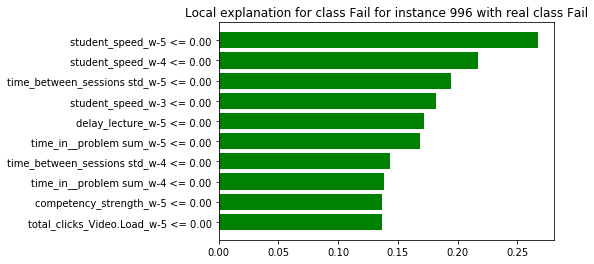

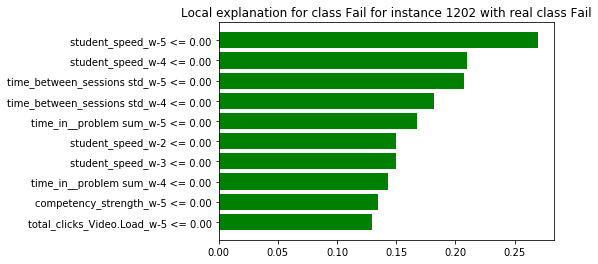

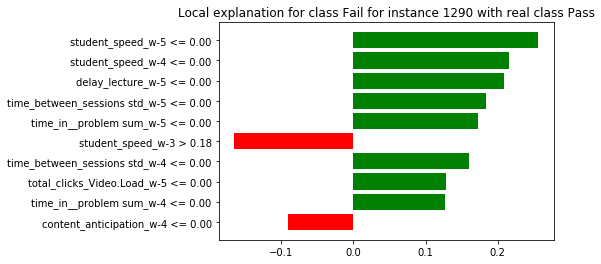

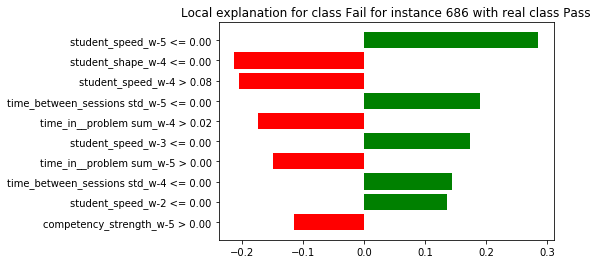

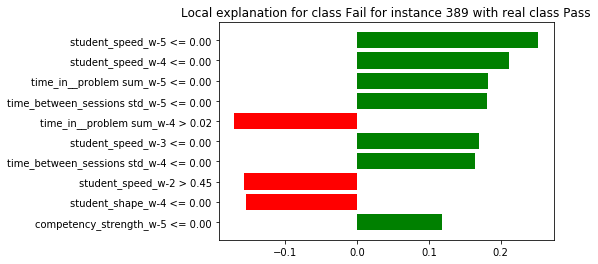

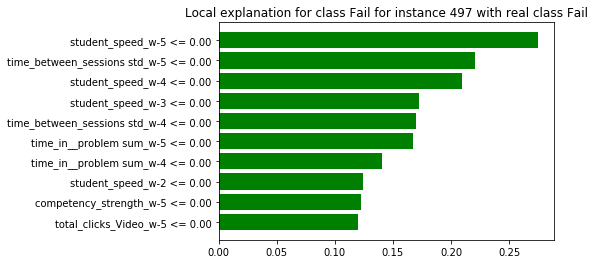

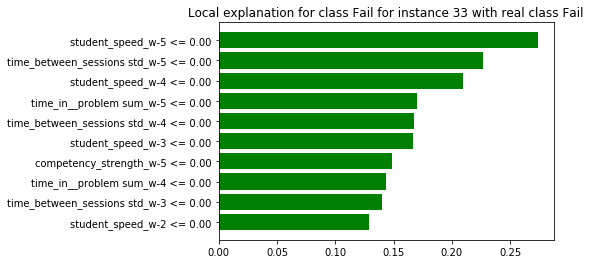

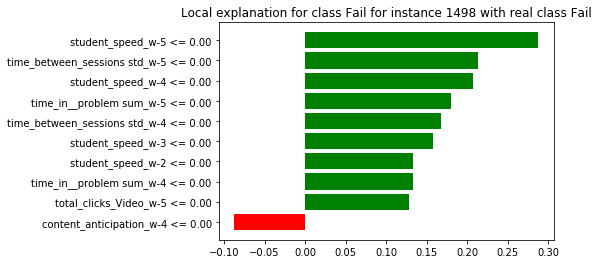

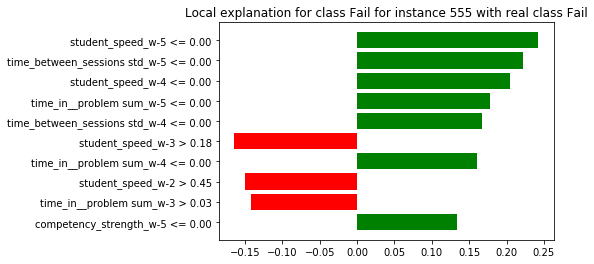

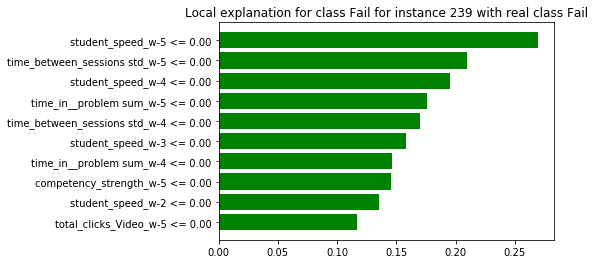

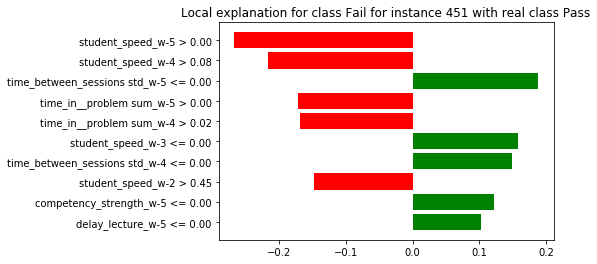

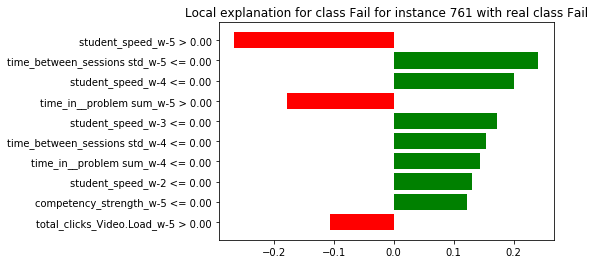

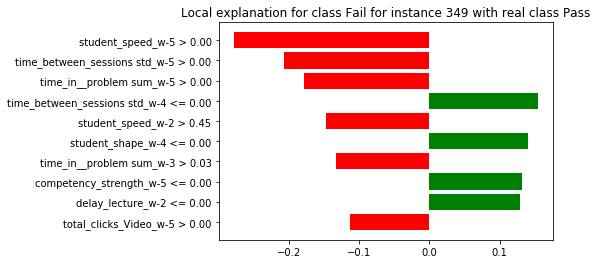

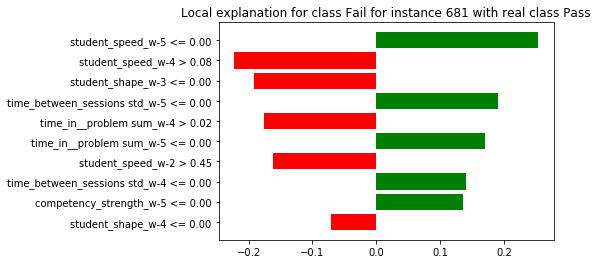

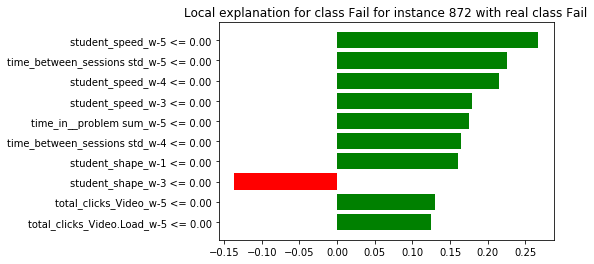

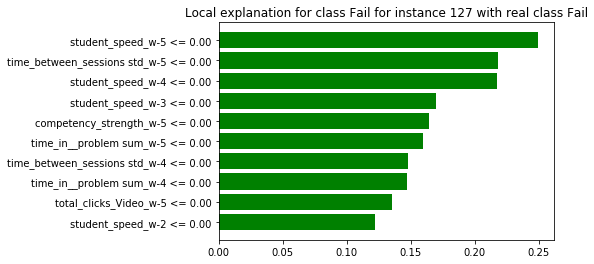

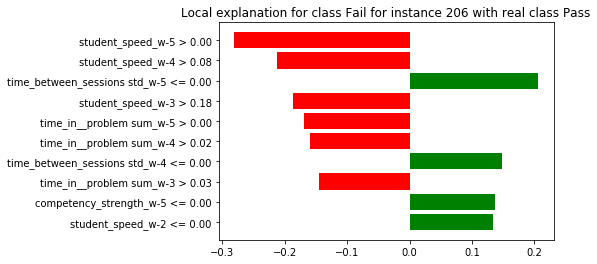

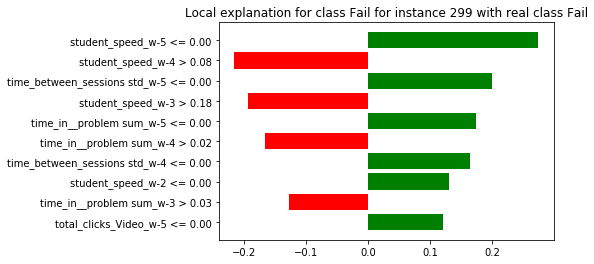

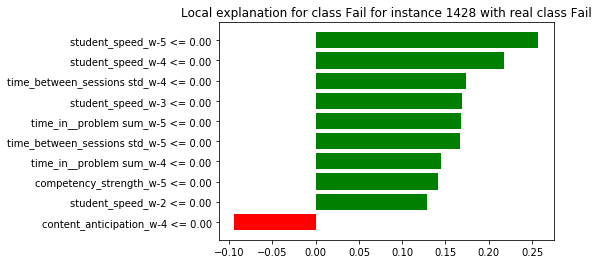

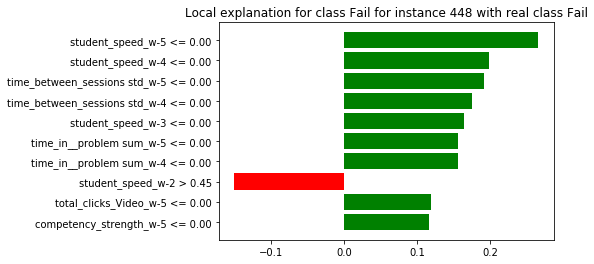

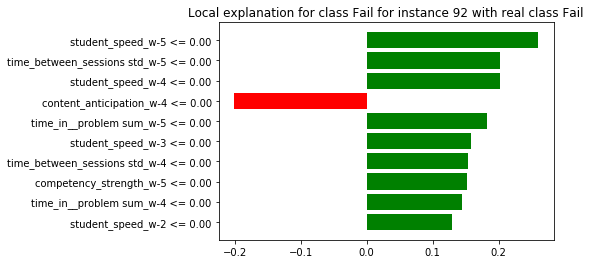

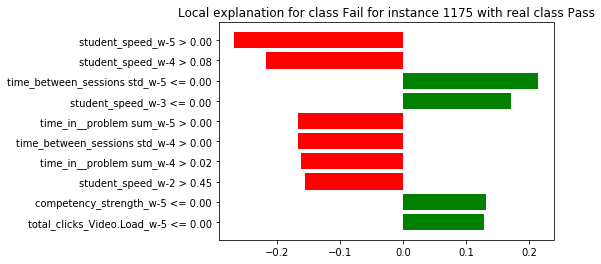

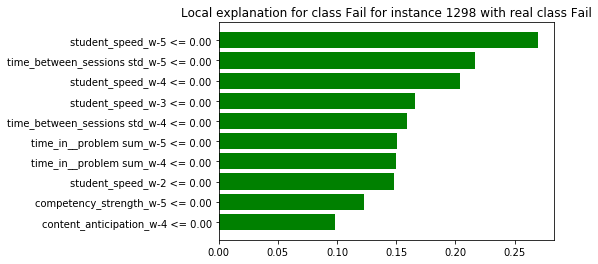

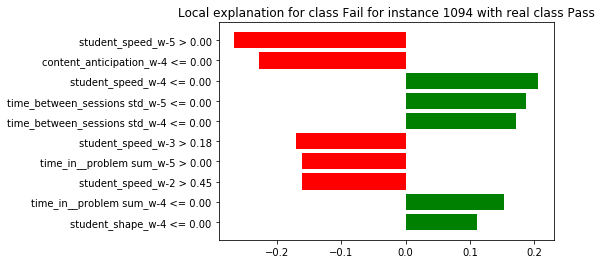

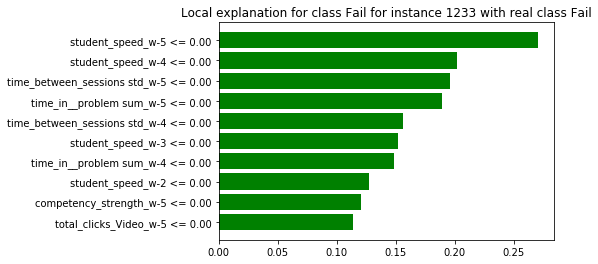

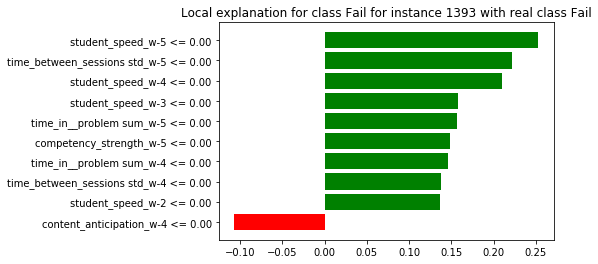

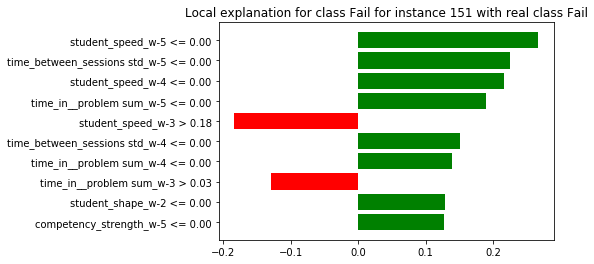

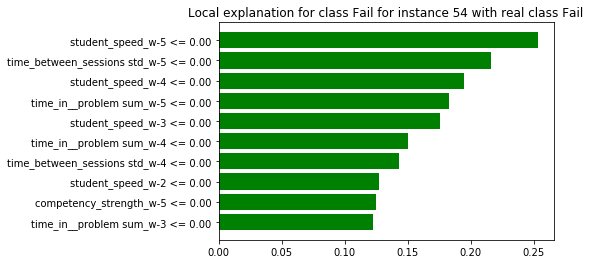

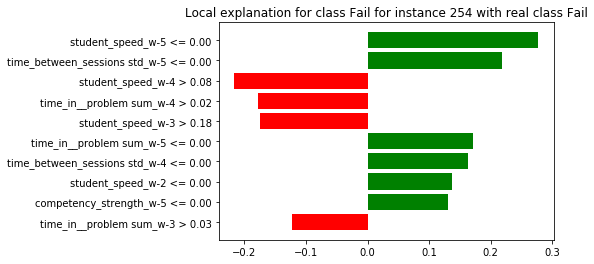

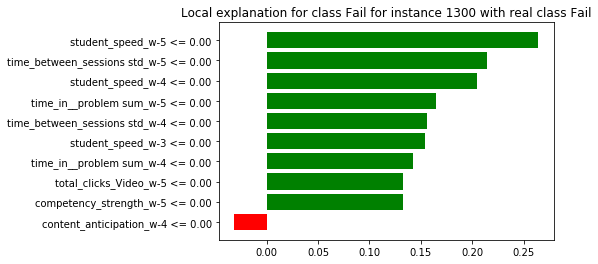

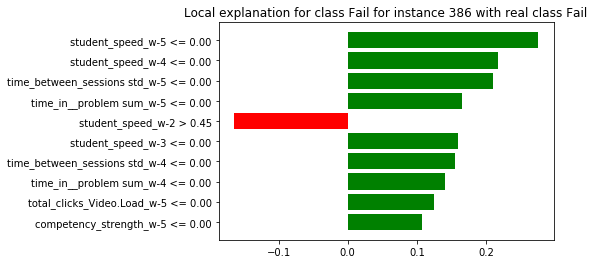

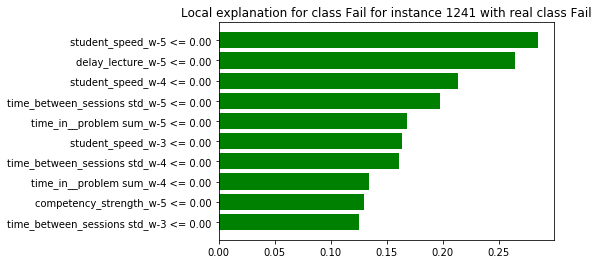

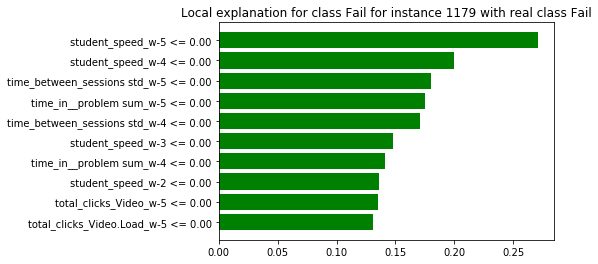

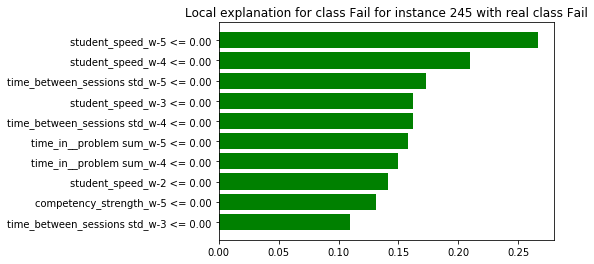

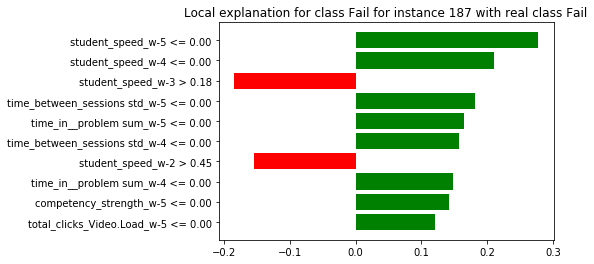

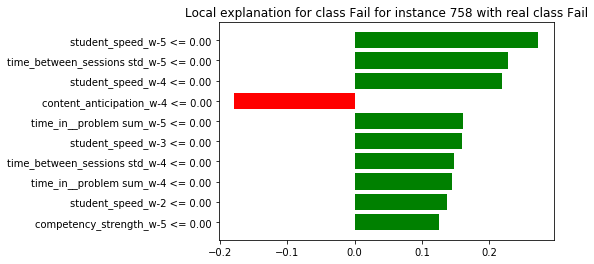

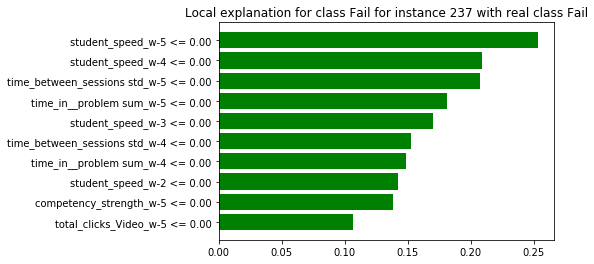

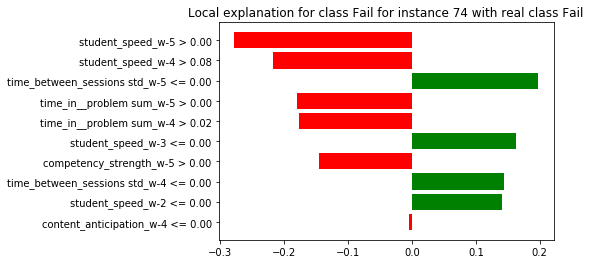

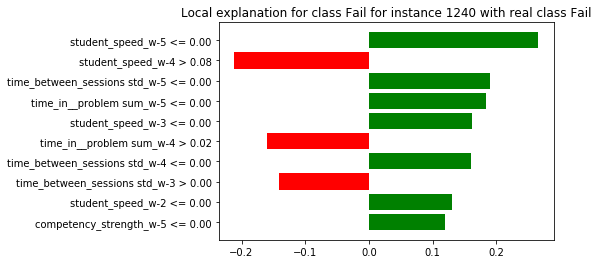

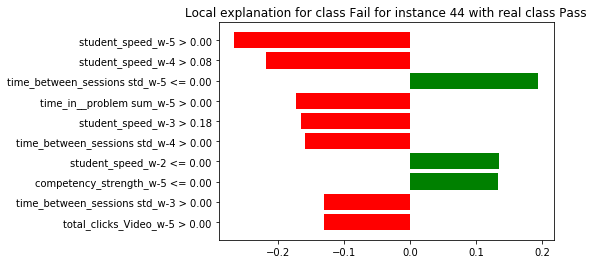

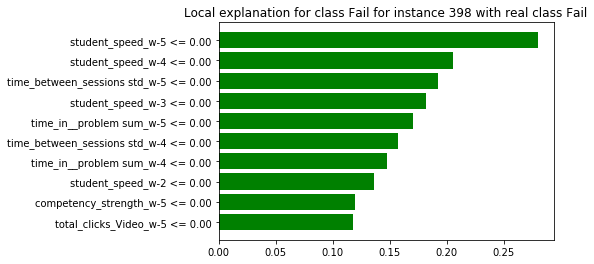

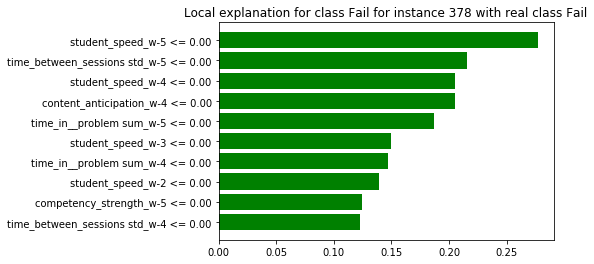

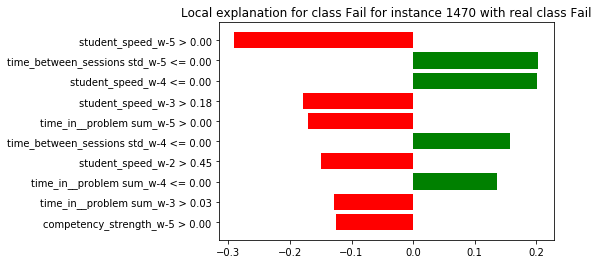

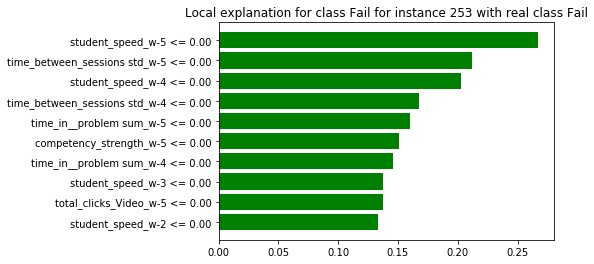

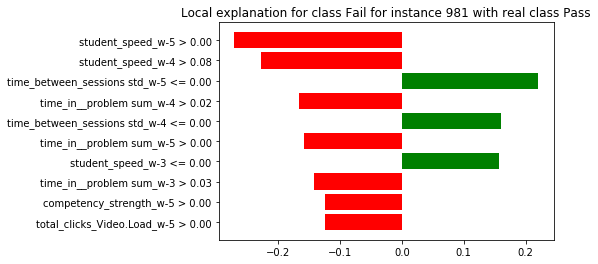

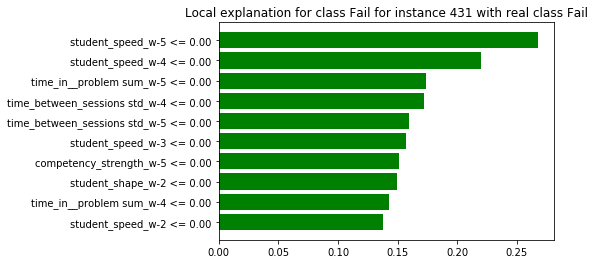

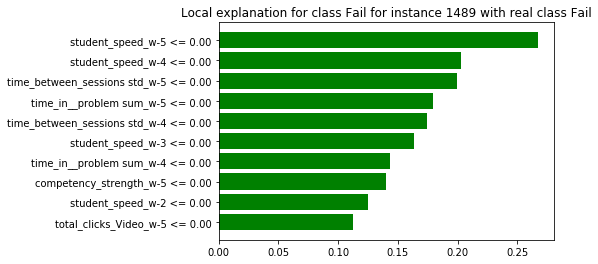

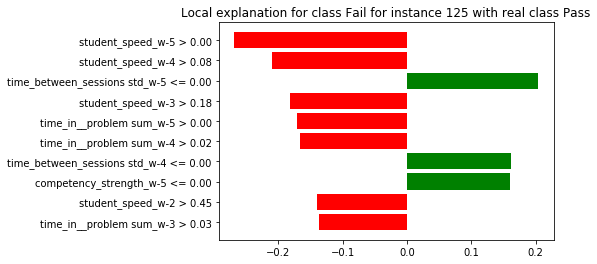

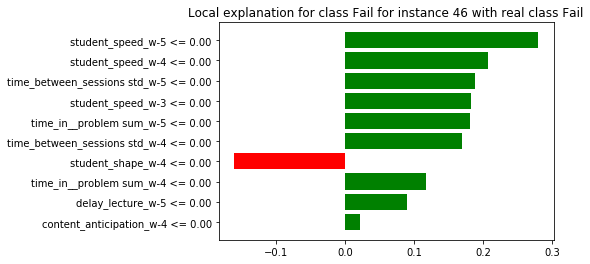

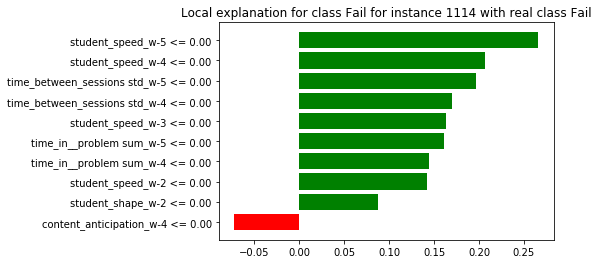

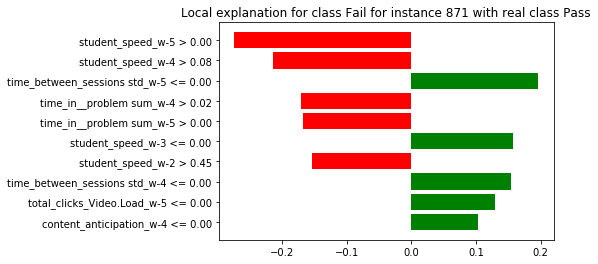

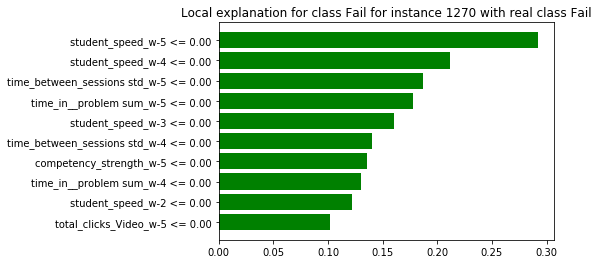

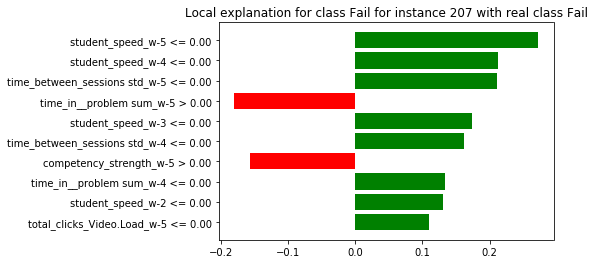

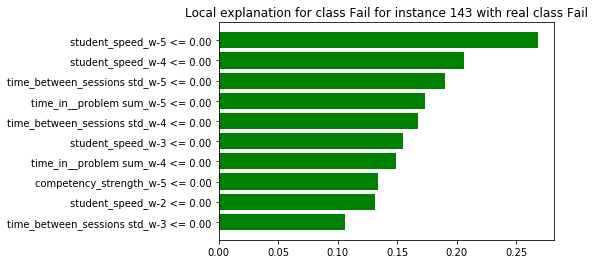

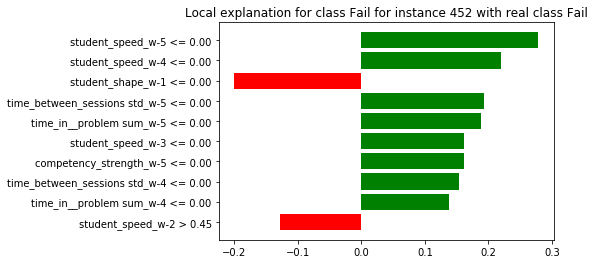

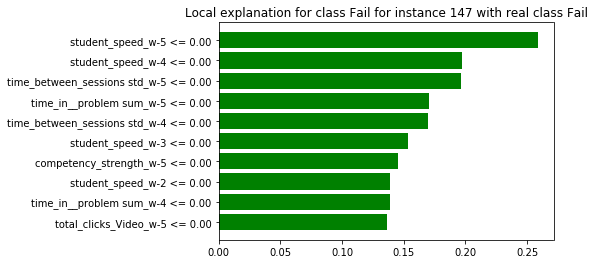

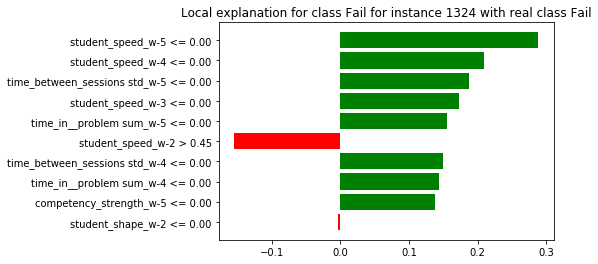

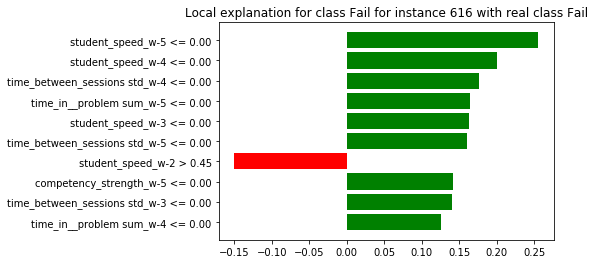

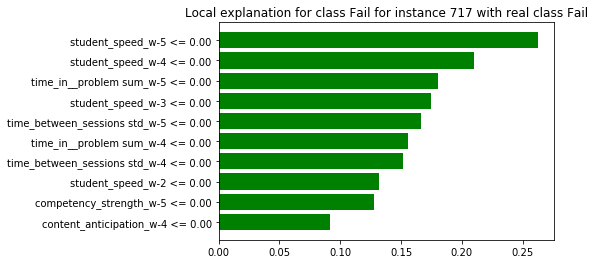

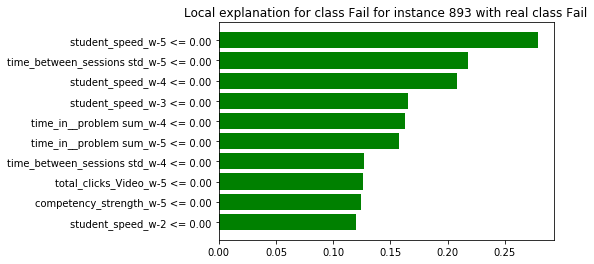

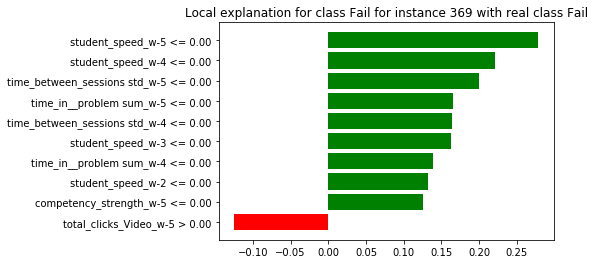

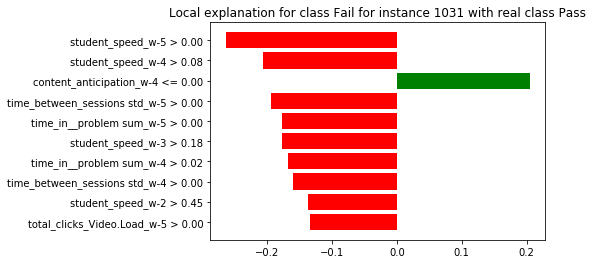

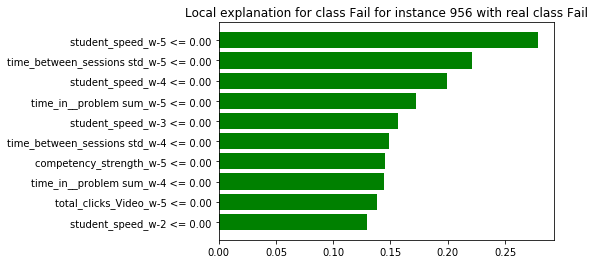

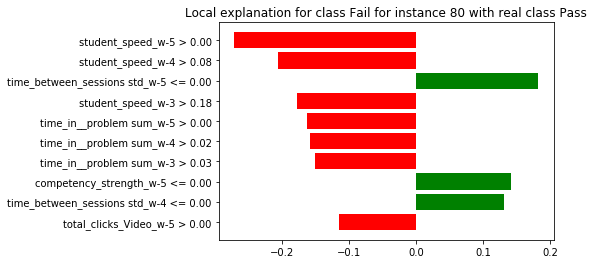

In [107]:
def pyplot_all(explainers, instances, real_labels):
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i, exp in enumerate(explainers):
        l = 'Fail' if real_labels[instances[i]] else 'Pass'
        label = exp.available_labels()[0]
        expl = exp.as_list(label=label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        vals = [x[1] for x in expl]
        names = [x[0] for x in expl]
        
        vals.reverse()
        names.reverse()
        colors = ['green' if x > 0 else 'red' for x in vals]
        pos = np.arange(len(expl)) + .5
        
        plt.barh(pos, vals, align='center', color=colors)
        plt.yticks(pos, names)
        if exp.mode == "classification":
            title = 'Local explanation for class %s for instance %d with real class %s' % (exp.class_names[label],instances[i],l)
        plt.title(title)
        plt.show()
pyplot_all(explainers, instances, y_train)

In [111]:
def DataFrame_all(explainers,instances,real_labels):
    df=pd.DataFrame({})
    class_names=['Pass', 'Fail']
    dfl = []
    suffix = ['_t-5', '_t-4', '_t-3', '_t-2', '_t-1', '_t-0']
    for i,exp in enumerate(explainers):
        this_label = exp.available_labels()[0]
        l = []
        l.append(("exp number", instances[i]))
        l.append(("real value", 'Fail' if real_labels[instances[i]] else 'Pass'))
        expl = exp.as_list(label=label)
        new_expl = []
        for e in expl:
            for j, s in enumerate(suffix):
                if e[0].find(s) != -1:
                    new_expl.append((e[0].replace(s, '_w-'+str(j)), e[1]))
                
        expl = new_expl
        l.extend(expl)
        dfl.append(dict(l))
    df = df.append(pd.DataFrame(dfl))
    dfl = [pd.DataFrame.from_dict(x, orient='index') for x in dfl]
    return df, dfl

In [112]:
df,dfl = DataFrame_all(explainers, instances, y_train)

In [113]:
df

exp number real value  student_speed_w-5 <= 0.00  \
0         1344       Fail                   0.285152   
1          532       Fail                   0.283324   
2          975       Fail                   0.258556   
3          141       Fail                   0.268077   
4          183       Pass                        NaN   
..         ...        ...                        ...   
95         893       Fail                   0.278466   
96         369       Fail                   0.278440   
97        1031       Pass                        NaN   
98         956       Fail                   0.278423   
99          80       Pass                        NaN   

    time_between_sessions std_w-5 <= 0.00  student_speed_w-4 <= 0.00  \
0                                0.193342                   0.192291   
1                                0.204382                   0.207065   
2                                0.227514                   0.202400   
3                                0.177203                   0.216624   
4                                0.216273                   0.219931   
..                                    ...                        ...   
95                               0.217833                   0.207923   
96                               0.199583                   0.220442   
97                                    NaN                        NaN   
98                               0.221305                   0.199141   
99                               0.182487                        NaN   

    time_in__problem sum_w-5 <= 0.00  time_between_sessions std_w-4 <= 0.00  \
0                           0.168005                               0.161939   
1                           0.170125                               0.151598   
2                           0.161346                               0.158891   
3                           0.178988                               0.134311   
4                                NaN                                    NaN   
..                               ...                                    ...   
95                          0.157836                               0.126655   
96                          0.165101                               0.164138   
97                               NaN                                    NaN   
98                          0.172679                               0.148510   
99                               NaN                               0.131190   

    student_speed_w-3 <= 0.00  student_speed_w-2 <= 0.00  \
0                    0.152272                   0.138273   
1                    0.144982                   0.136874   
2                    0.174389                        NaN   
3                    0.157238                   0.131884   
4                         NaN                        NaN   
..                        ...                        ...   
95                   0.165314                   0.120003   
96                   0.162718                   0.132044   
97                        NaN                        NaN   
98                   0.156800                   0.129692   
99                        NaN                        NaN   

    time_in__problem sum_w-4 <= 0.00  ...  \
0                           0.131885  ...   
1                           0.150676  ...   
2                           0.136561  ...   
3                           0.141992  ...   
4                           0.144241  ...   
..                               ...  ...   
95                          0.162544  ...   
96                          0.139062  ...   
97                               NaN  ...   
98                          0.144272  ...   
99                               NaN  ...   

    time_between_sessions std_w-5 > 0.00  time_in__problem sum_w-4 > 0.02  \
0                                    NaN                              NaN   
1                                    NaN                              NaN   
2                       